---

<h1><center> Ensemble methods and hyperparameter tuning </center></h1>

---




In this project we will apply several classification models to a problem in astrophysics. The problem is described [here](https://satyam5120.medium.com/predicting-a-pulsar-star-using-different-machine-learning-algorithms-d22ee8fc71b4) and [here](https://www.kaggle.com/datasets/colearninglounge/predicting-pulsar-starintermediate). It consists in labeling objects in space as pulsars or not pulsars, based on the properties of an integrated profile of observations and the DM-SNR curve. The given dataset has 8 feature columns:
1. Mean of the integrated profile.
2. Standard deviation of the integrated profile.
3. Excess kurtosis of the integrated profile.
4. Skewness of the integrated profile.
5. Mean of the DM-SNR curve.
6. Standard deviation of the DM-SNR curve.
7. Excess kurtosis of the DM-SNR curve.
8. Skewness of the DM-SNR curve.

Our procedure will follow these steps:
1. Load the data
2. Remove incomplete samples
3. Visual inspection of histograms, box plots, and correlation matrix
4. Extracting the test dataset
5. Hyperparameter tuning of of logistic regression with grid search
6. Support vector machine
7. Random forest
8. AdaBoost
9. Gradient Boosted Trees
10. Final model selection

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import Utils

# 1. Load the data

+ Load the data file `pulsar_data.csv` into a Pandas dataframe using [`pd.read_csv`](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html)
+ Save the column headers corresponding to feature names to the variable `feature_names`

In [3]:
df = pd.read_csv('pulsar_data.csv')

feature_names = df.columns[: -1]
D = len(feature_names)

# 2. Remove incomplete samples
The image below is a visualization of [`df.isnull()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.isnull.html). We notice that 3 of the features have a significant number of missing (null) values.

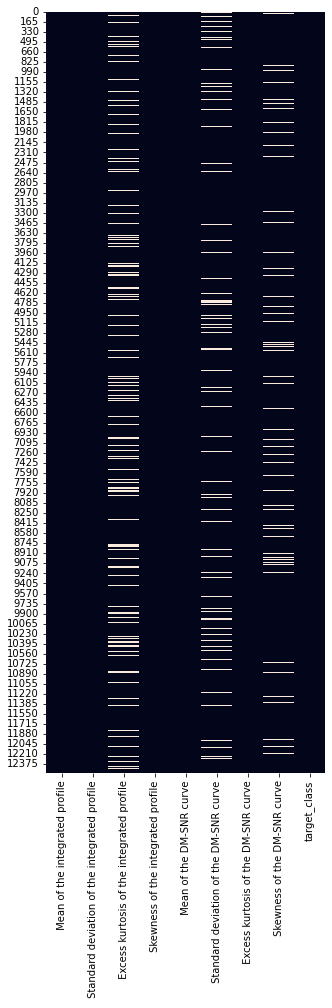

In [4]:
plt.figure(figsize = (5, 14))

sns.heatmap(df.isnull(),  cbar = False)

plt.show()

### 2.1 Count null values

Find the number of null values for each feature column of `df` (excluding `target_class`). Store the null counts in the provided dictionary.

In [5]:
null_counts = dict().fromkeys(feature_names)

for feat in feature_names:
    null_counts[feat] = np.count_nonzero(df[feat].isnull())

### 2.2 Remove rows with null values

Remove all rows from the data frame that contain null values

In [6]:
df = df.dropna()

# 3. Class imbalance

Find the number of data points in each of the two classes. Save the number of class 0 data and class 1 data to `N0` and `N1` respectively.

In [7]:
N0 = np.count_nonzero(df['target_class'] == 0)
N1 = np.count_nonzero(df['target_class'] == 1)

# Plotting p(X)

Here are two visualizations of the marginal distribution of each of the inputs. The one on the left is a histogram, created with seaborn's `histplot`. The one on the right is a box or whisker plot, created with seaborn's `boxplot`. 

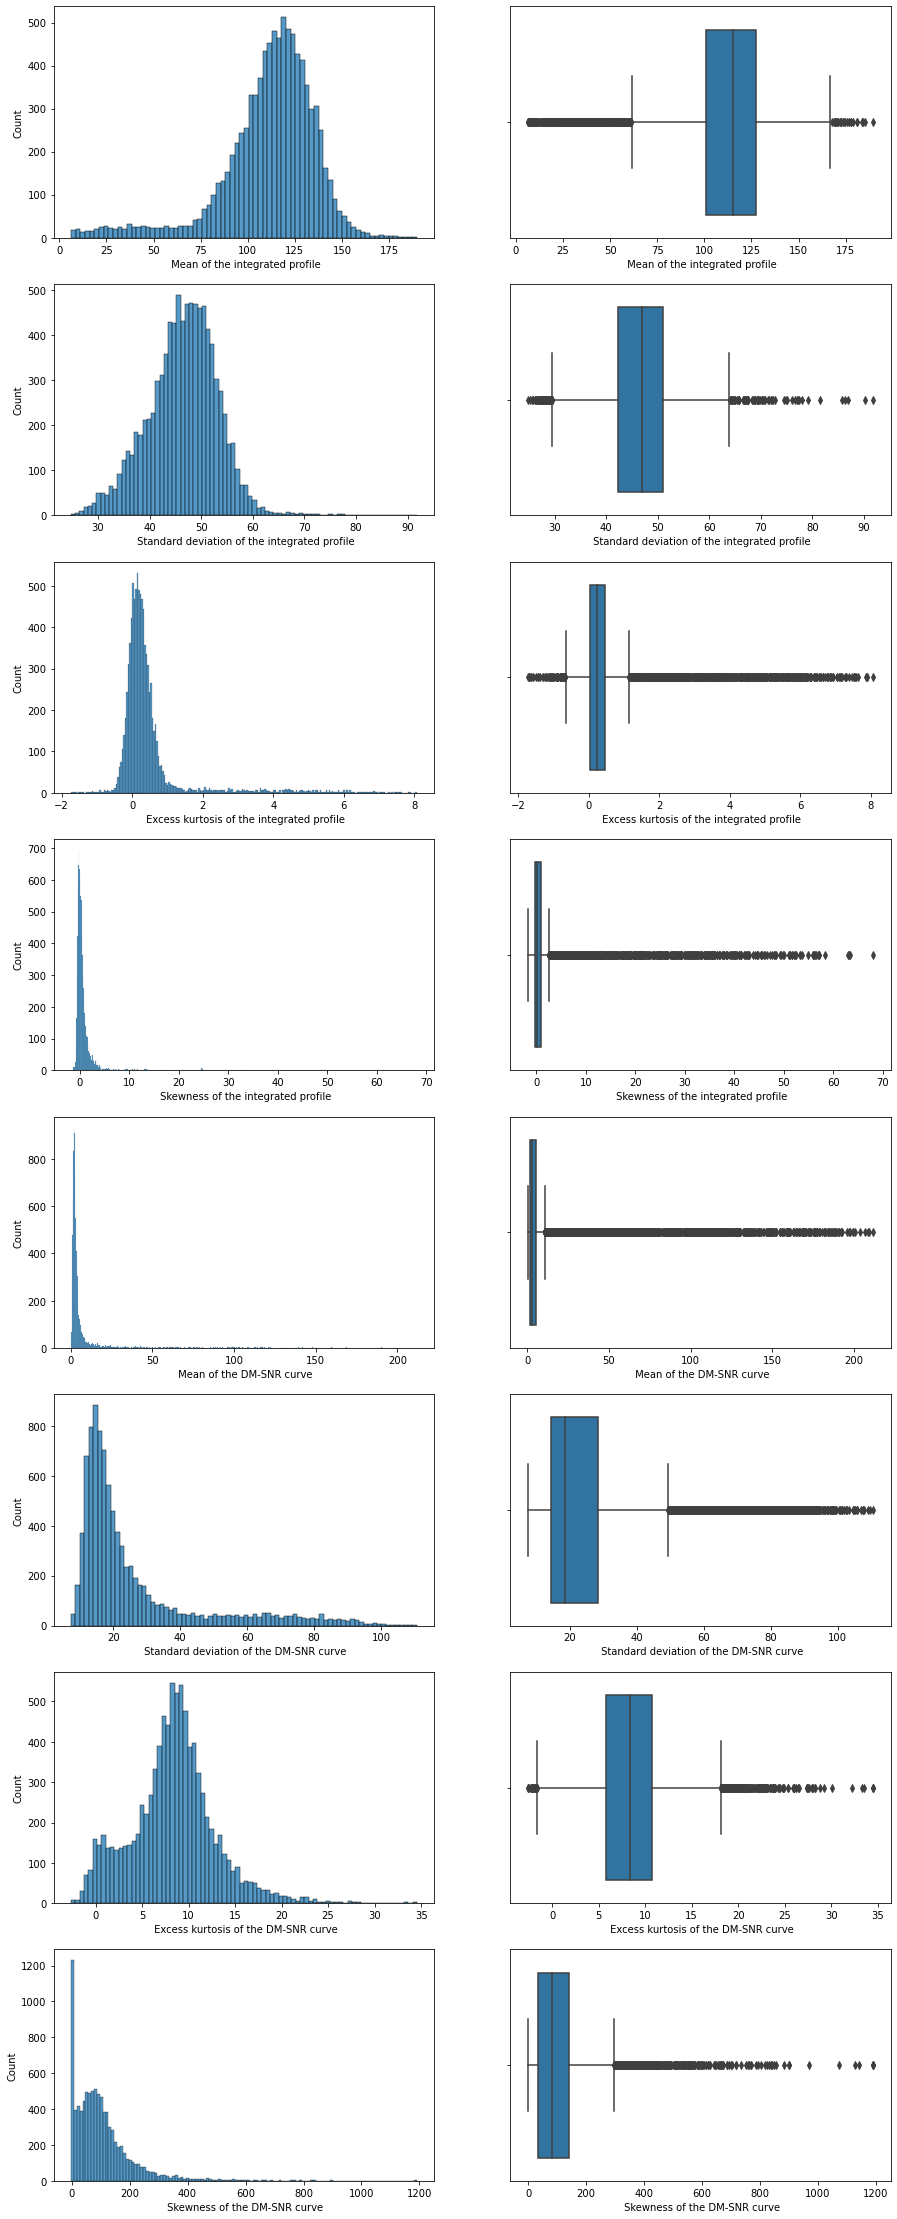

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

In [8]:
fig, axes = plt.subplots(nrows = D, ncols = 2,  figsize = (15, 40))

for i in range(D):
    feature = feature_names[i]
    
    plt.figure(figsize = (5, 5))
    
    sns.histplot(x = df[feature], ax = axes[i][0])
    sns.boxplot(x = df[feature], ax = axes[i][1])

# Plotting p(X|Y)

Below we see boxplots applied to the features conditioned on each of the target values (0 and 1). A feature whose two conditional distributions are well-separated will likely be a good feature for classification.

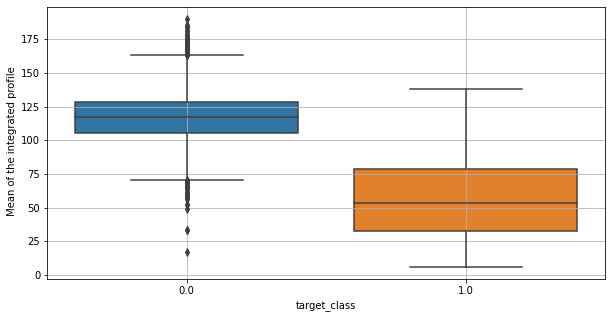

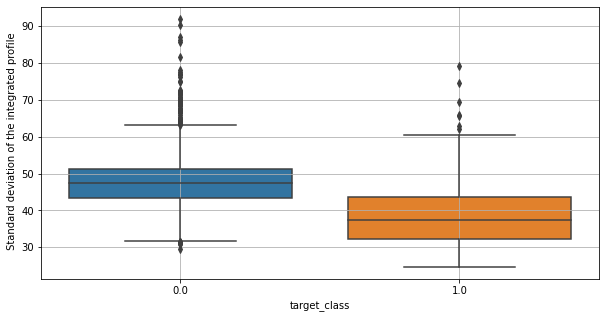

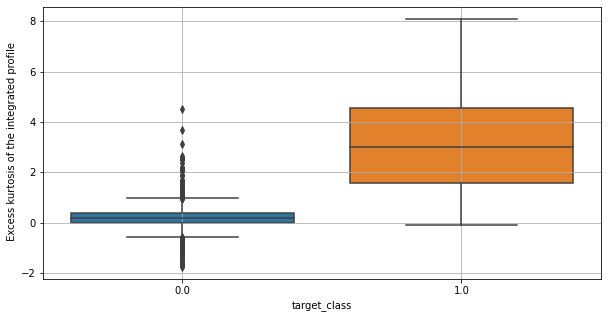

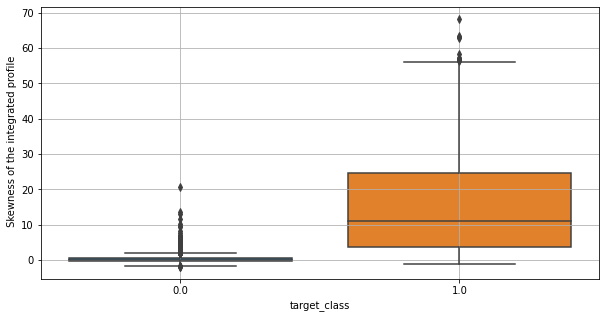

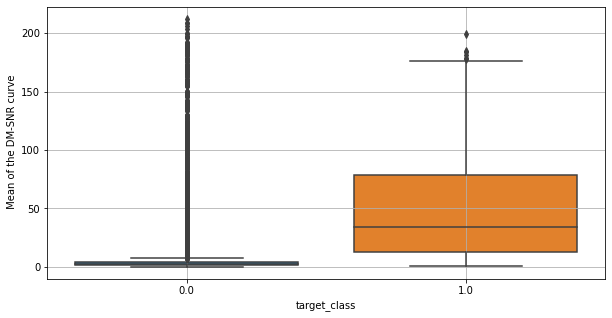

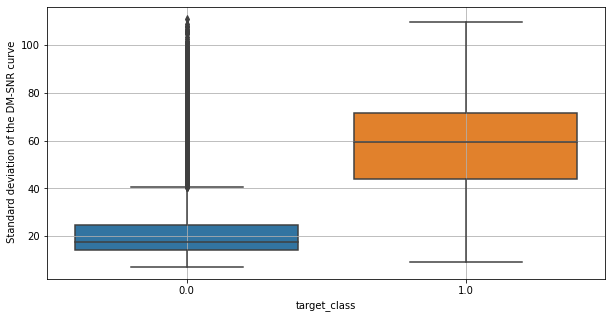

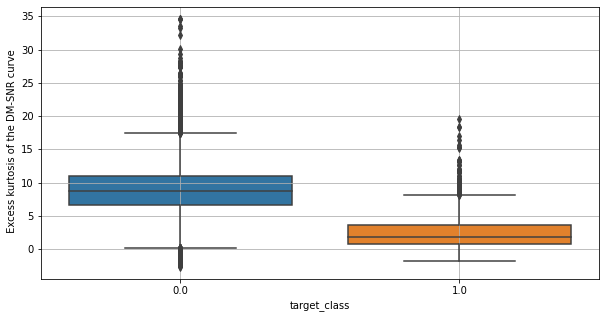

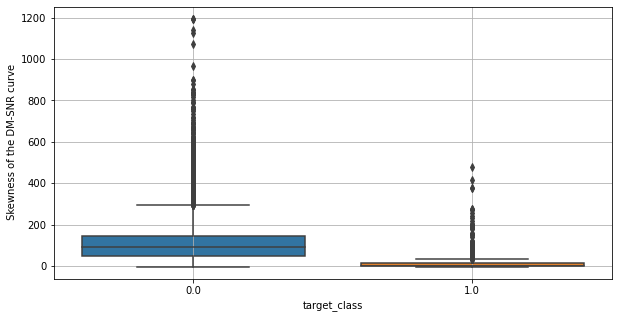

In [9]:
for feature in feature_names:
    plt.figure(figsize = (10, 5))
    
    sns.boxplot(x = 'target_class', y = feature, data = df)
    
    plt.grid()

# Correlation matrix (X,Y)
The next cell color-codes the correlation matrix of (X,Y).

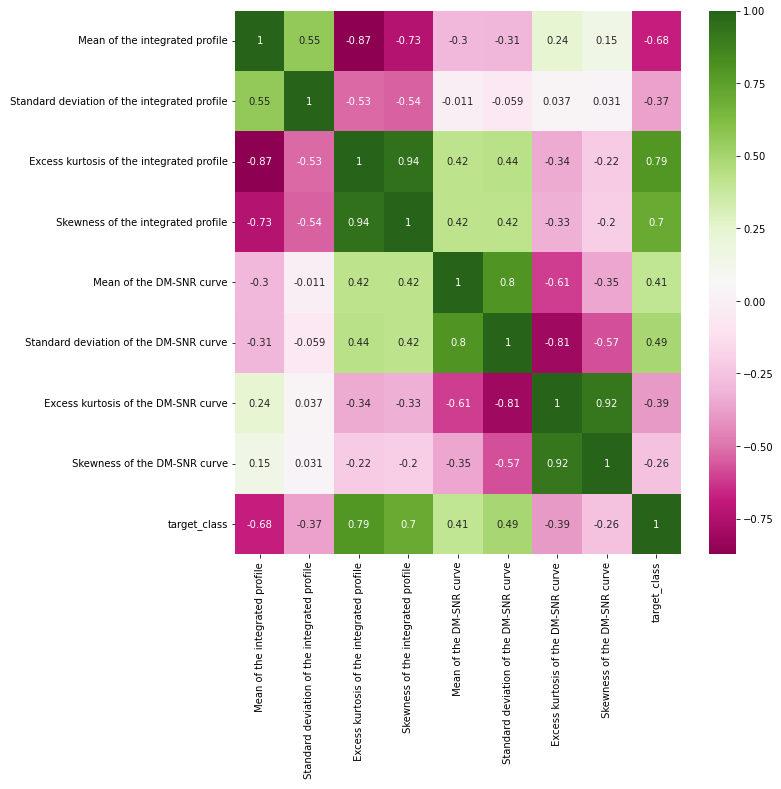

In [10]:
plt.figure(figsize = (10, 10))

corr_mat = df.corr()

sns.heatmap(corr_mat, xticklabels = corr_mat.columns, yticklabels = corr_mat.columns, annot = True, cmap = "PiYG")

plt.show()

# 4. Extracting the test dataset

Split the dataset contained in `df` into trainging and testing parts, with 90% used for training and 10% for testing.

In [11]:
from sklearn.model_selection import train_test_split

y = df.pop('target_class').to_numpy()
X = df.to_numpy()

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.1)

# 5.1. Logistic Regression

In this part we will use grid search to choose the values of the hyperparameters of a logistic regression pipeline. Begin by creating a pipeline with a `StandardScaler` followed by `LogisticRegression` classifier, in which we will use `liblinear` as  `solver`. 

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

model = Pipeline([
    ('scaler' , StandardScaler()) ,
    ('clf' , LogisticRegression(solver = 'liblinear'))
])

model = model.fit(Xtrain, ytrain)

# 5.2 Hyperparameter tuning with grid search

Run gridsearch (`GridSearchCV`) with 5-fold cross validation. The parameters to search over are:

+ the regularization function ('l1' or 'l2'), and
+ the value of C. C should take values np.logspace(-4, 4, 5).

We use the following parameters in the `GridSearchCV` contructor.
+ `scoring=['accuracy', 'precision','recall']`,
+ `cv=5`,
+ `refit='accuracy'`

`Utils.py` contains useful functions for unpacking and plotting the results of the grid search. Use the `unpack_gridsearch` method to extract useful information from the grid search solution. This method returns:
1. A pandas dataframe with the cross-validated performance metrics for each point on the grid.
2. A dictionary with the best-case hyperparameter values
3. The classifier with best-case hyperparameters assigned


D:\Programs\Conda\envs\sdse\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Programs\Conda\envs\sdse\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Programs\Conda\envs\sdse\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Programs\Conda\envs\sdse\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning

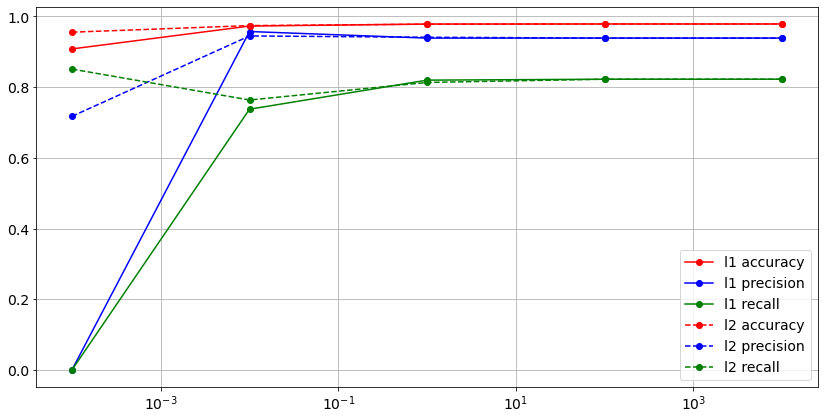

In [14]:
from sklearn.model_selection import GridSearchCV

param_grid_logreg = {
    'clf__penalty' : ['l1', 'l2'],
    'clf__C' : np.logspace(-4, 4, 5)}

grid = GridSearchCV(model, param_grid_logreg, scoring = ['accuracy', 'precision', 'recall'], cv = 5, refit = 'accuracy')

grid_result = grid.fit(Xtrain, ytrain)

df_logreg, best_param_logreg, best_logreg = Utils.unpack_gridsearch(grid_result, param_grid_logreg)

# Visualize with plot_grid (included in lab6_utils.py)
Utils.plot_grid(df_logreg, param_grid_logreg)

# Package it into a function

Next we will repeat this process with several other classification models. To keep the code clean, we will collect the steps into a single function. This function should receive as inputs:
1. The classifier object, e.g. `LogisticRegression(solver='liblinear',random_state=rng_seed)`
2. The `param_grid` dictionary that defines the search space for `GridSearchCV`.

It should:
1. Create the pipeline mode
2. Construct the `GridSearchCV` object
3. Run `fit` on the grid search object, using the training data (no need to pass the data in, it's global)
4. Run `unpack_gridsearch` to obtain `df`, `best_params`, `best_clf`
5. Plot the result with `Utils.plot_grid`
6. `retun df_clf, best_param_clf, best_clf`

In [15]:
def build_grid_plot(clf, param_grid):
    model = Pipeline([
        ('scaler' , StandardScaler()) ,
        ('clf' , clf)
    ])

    grid = GridSearchCV(model, param_grid, scoring = ['accuracy', 'precision', 'recall'], cv = 5, refit = 'accuracy')

    grid_result = grid.fit(Xtrain, ytrain)

    df_clf, best_param_clf, best_clf  = Utils.unpack_gridsearch(grid_result, param_grid)

    Utils.plot_grid(df_clf, param_grid)

    return df_clf, best_param_clf, best_clf

# Additional models
Next we will repeat this exercise for four additional model types: SVMs, Random forests, AdaBoost, and Gradient boosted trees. In each case, we will use the suggested parameter grid. 

# 6. Support vector machine

+ kernel: ['poly','rbf']
+ C: np.logspace(-2, 2, 5)

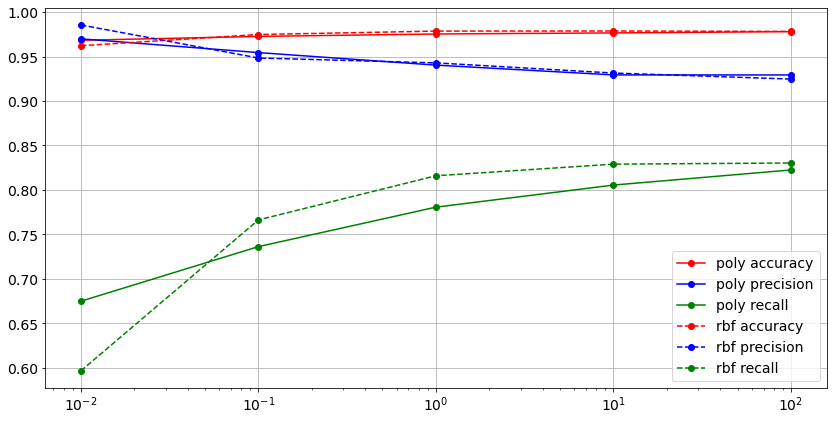

CPU times: total: 21.6 s
Wall time: 21.6 s


In [16]:
%%time

from sklearn.svm import SVC

param_grid_svm =  {
    'clf__kernel' : ['poly','rbf'],
    'clf__C' : np.logspace(-2, 2, 5)
}

df_svc, best_param_svc, best_svc = build_grid_plot(SVC(), param_grid_svm)

# 7. Random forest

+ max_features: ['sqrt','log2']
+ n_estimators: np.linspace(2, 100, 5, dtype=int)

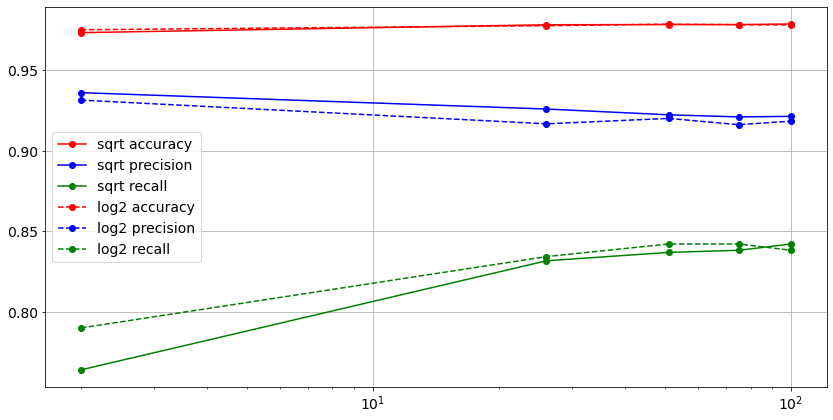

CPU times: total: 21.7 s
Wall time: 21.8 s


In [17]:
%%time

from sklearn.ensemble import RandomForestClassifier

param_grid_rf = {
    'clf__max_features': ['sqrt', 'log2'],
    'clf__n_estimators' : np.linspace(2, 100, 5, dtype = int)
}

df_rf, best_param_rf, best_rf = build_grid_plot(RandomForestClassifier(), param_grid_rf)

# 8. AdaBoost

+ learning_rate: [0.01,0.1]
+ n_estimators: np.linspace(10, 100, 5, dtype=int)

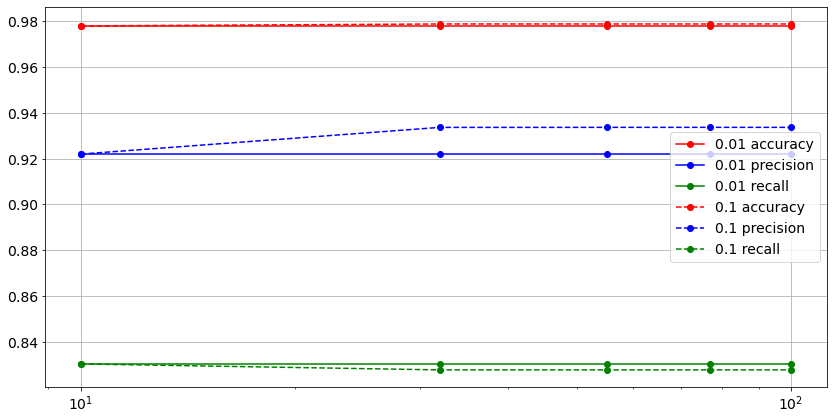

CPU times: total: 17.7 s
Wall time: 17.7 s


In [18]:
%%time

from sklearn.ensemble import AdaBoostClassifier

param_grid_ab = {
    'clf__learning_rate': [0.01, 0.1],
    'clf__n_estimators' : np.linspace(10, 100, 5, dtype = int)
}

df_ab, best_param_ab, best_ab = build_grid_plot(AdaBoostClassifier(), param_grid_ab)

# 9. Gradient Boosted Trees

+ learning_rate: [0.1,1.0]
+ n_estimators' : [50,75,100]

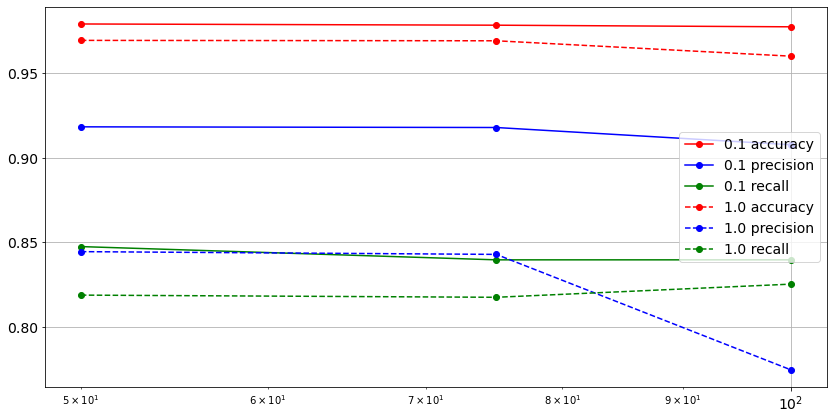

CPU times: total: 27.5 s
Wall time: 27.5 s


In [20]:
%%time

from sklearn.ensemble import GradientBoostingClassifier

param_grid_gbc = {
    'clf__learning_rate': [0.1, 1.0],
    'clf__n_estimators' : [50, 75, 100]
}

df_gbc, best_param_gbc, best_gbc = build_grid_plot(GradientBoostingClassifier(), param_grid_gbc)

# 10. Final model selection

We will choose the best classifier on the basis of the accuracy obtained in the grid search. Assign it to `best_clf`. Then compute the test accuracy, precision, and recall.

In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

best_clf = best_gbc

ypred = best_clf.predict(Xtest)

print(accuracy_score(ytest, ypred))
print(precision_score(ytest, ypred))
print(recall_score(ytest, ypred))

0.978448275862069
0.9
0.8571428571428571
